In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
df_vamstar = pd.read_csv('/content/drive/MyDrive/Data_Science/DataSets/InterviewAnalysisMolecule.tsv', sep='\t')
df_vamstar.head(3)

,contract_id,published_date,start_date,duration_extension,outcome,second_place_outcome,buyer,region,atc,duration,contract_type,sku,end_date_extension,participants_no,quantity_annual,quantity_total,maximum_price_allowed,active_ingredient,pack_strength,participants,participants_price,published_date_month,winner,winner_price,second_place,second_place_price
0,1,2013-05-16,2013-05-24,10,won,NaN,buyer_1,region_1,C07AB07,39,regional,molecule_x_10mg_tablet,2017-06-30,1,9860,32966.511085,0.10000,molecule_x,10mg,participants_16,0.0004,2013-05-01,participants_16,0.0004,NaN,NaN
1,2,2013-04-29,2013-06-21,0,won,NaN,buyer_2,region_2,C07AB07,48,wide area,molecule_x_10mg_tablet,2017-06-30,1,54988,220249.442660,63442.21000,molecule_x,10mg,participants_16,0.007,2013-04-01,participants_16,0.0070,NaN,NaN
2,3,2013-06-09,2014-08-14,6,won,lost,buyer_3,region_3,C07AB07,12,regional,molecule_x_10mg_tablet,2016-02-14,2,1904,2680.639219,0.11635,molecule_x,10mg,participants_16|participants_23,0.014|0.07071,2013-06-01,participants_16,0.0140,participants_23,0.07071


My interpretation of this exercise is to create a series of steps that will help ensure the quality of data with the objective of using it later on to train models. To do so I will create different functions to meet these needs.

I will not carry out any sort of analysis due to the size of the sample set.

## Null values review

In [ ]:
df_vamstar.isna().sum()

contract_id               0
published_date            0
start_date                0
duration_extension        0
outcome                   0
second_place_outcome     16
buyer                     0
region                    0
atc                       1
duration                  0
contract_type             0
sku                       0
end_date_extension        0
participants_no           0
quantity_annual           0
quantity_total            0
maximum_price_allowed     0
active_ingredient         0
pack_strength             0
participants              0
participants_price        0
published_date_month      0
winner                    0
winner_price              0
second_place             16
second_place_price       16
dtype: int64

The only value we see with a null that could have an impact in the model is in column **'atc'**, since the remaining ones could mean that there was only one participant thus there was no second place.

Prior to removing the row lets check what possible values this row can take.

In [ ]:
#Check the possible values the column atc can take, including nulls.
df_vamstar.atc.value_counts(dropna=False)

atc
C07AB07    30
NaN         1
Name: count, dtype: int64

We see that all entries contain the same code, thus we could assign the same code to row with the missing entry, or simply no take into account the column when training the model and dropping it entirely. For the sake of keeping the model simple I will drop the column, since its unikely that it can be used as a predicting factor.

**Important note**: I have dropped the column based on the assumption that the possible values of the set are the ones show, if we have a larger sample size with varying values I would treat this null in a different way, perhaps dropping the row and not the column.

In [ ]:
#We remove the column atc.
df_vamstar.drop(['atc'], axis=1,inplace=True)

## Duplicate detector function.
With the objective of using the funtion as a error detector to identify potential errors in the quality of data.

The objective would be to apply this formula to those fields that should contain unique values, such as **Contract_id**


In [ ]:
def duplicate_detector(column):
    # Count unique values in the column
    unique = len(pd.unique(column))
    # Count total number of values in the column
    total = len(column)
    duplicated_values = column[column.duplicated(keep=False)].unique()
    if unique != total:
        return duplicated_values
    else:
        return 'NO DUPLICATES IN ' + column.name

def check_duplicates(df):
    duplicate_columns = {}
    for column in df.columns:
        result = duplicate_detector(df[column])
        if result is not None:
            duplicate_columns[column] = result
    return duplicate_columns



#The objective of this function is not too apply it to the entire DataFrame, but only to the columns in the table that should contain unique values (Contract_id).
#This would be an easy way to detect error in the quality of Data.
#In this case I will apply it to all columns just to test the output.

duplicate_columns = check_duplicates(df_vamstar)
if duplicate_columns:
    print("Duplicate values found in the following columns:")
    for column, values in duplicate_columns.items():
        print(f"Column: {column}, Duplicated values: {values}")
else:
    print("No duplicates found in any column.")


Duplicate values found in the following columns:
Column: contract_id, Duplicated values: NO DUPLICATES IN contract_id
Column: published_date, Duplicated values: NO DUPLICATES IN published_date
Column: start_date, Duplicated values: ['2020-08-04']
Column: duration_extension, Duplicated values: [10  0  6  3 12]
Column: outcome, Duplicated values: ['won']
Column: second_place_outcome, Duplicated values: [nan 'lost']
Column: buyer, Duplicated values: ['buyer_2' 'buyer_3' 'buyer_5' 'buyer_7' 'buyer_8' 'buyer_11' 'buyer_12'
 'buyer_16' 'buyer_19']
Column: region, Duplicated values: ['region_2' 'region_3' 'region_4' 'region_5' 'region_6' 'region_7'
 'region_8' 'region_9' 'region_11' 'region_12']
Column: duration, Duplicated values: [48 12 36 24]
Column: contract_type, Duplicated values: ['regional' 'multi-region']
Column: sku, Duplicated values: ['molecule_x_10mg_tablet']
Column: end_date_extension, Duplicated values: ['2017-06-30' '2023-08-03']
Column: participants_no, Duplicated values: [1 

This could be the first quality control on the data.

## No nulls in primary key

A crucial data cleaning step is to check that there are no null values in our primary key. In the first step we checked for duplicated, and now, we will drop rows that contain nulls in our primary key **Contract_id**

In [ ]:
def remove_null_rows(df, column):

    return df.dropna(subset=[column])

remove_null_rows(df_vamstar,'contract_id')

,contract_id,published_date,start_date,duration_extension,outcome,second_place_outcome,buyer,region,duration,contract_type,sku,end_date_extension,participants_no,quantity_annual,quantity_total,maximum_price_allowed,active_ingredient,pack_strength,participants,participants_price,published_date_month,winner,winner_price,second_place,second_place_price
0,1,2013-05-16,2013-05-24,10,won,NaN,buyer_1,region_1,39,regional,molecule_x_10mg_tablet,2017-06-30,1,9860,3.296651e+04,0.10000,molecule_x,10mg,participants_16,0.0004,2013-05-01,participants_16,0.00040,NaN,NaN
1,2,2013-04-29,2013-06-21,0,won,NaN,buyer_2,region_2,48,wide area,molecule_x_10mg_tablet,2017-06-30,1,54988,2.202494e+05,63442.21000,molecule_x,10mg,participants_16,0.007,2013-04-01,participants_16,0.00700,NaN,NaN
2,3,2013-06-09,2014-08-14,6,won,lost,buyer_3,region_3,12,regional,molecule_x_10mg_tablet,2016-02-14,2,1904,2.680639e+03,0.11635,molecule_x,10mg,participants_16|participants_23,0.014|0.07071,2013-06-01,participants_16,0.01400,participants_23,0.070710
3,4,2013-05-04,2013-05-17,19,won,NaN,buyer_4,region_4,36,regional,molecule_x_10mg_tablet,2017-12-31,1,1652,5.900676e+03,0.03000,molecule_x,10mg,participants_16,0.025,2013-05-01,participants_16,0.02500,NaN,NaN
4,5,2013-12-18,2013-12-17,6,won,NaN,buyer_5,region_5,36,regional,molecule_x_10mg_tablet,2017-06-30,1,1000,3.289223e+03,0.00010,molecule_x,10mg,participants_16,1e-05,2013-12-01,participants_16,0.00001,NaN,NaN
5,6,2013-12-06,2014-02-21,14,won,NaN,buyer_6,region_6,48,regional,molecule_x_10mg_tablet,2019-04-20,1,2088,9.026168e+03,0.02550,molecule_x,10mg,participants_16,0.019,2013-12-01,participants_16,0.01900,NaN,NaN
6,7,2014-02-24,2014-01-01,3,won,NaN,buyer_7,region_7,12,regional,molecule_x_10mg_tablet,2015-03-31,1,16490,1.728231e+04,0.00005,molecule_x,10mg,participants_16,1e-05,2014-02-01,participants_16,0.00001,NaN,NaN
7,8,2014-03-08,2014-05-22,10,won,lost,buyer_8,region_8,36,regional,molecule_x_10mg_tablet,2018-03-22,4,10332,3.195179e+04,0.08000,molecule_x,10mg,participants_16|participants_5|participants_6|...,0.03|0.08|0.034|0.04066,2014-03-01,participants_16,0.03000,participants_6,0.034000
8,9,2014-03-18,2014-05-30,6,won,NaN,buyer_9,region_9,24,regional,molecule_x_10mg_tablet,2016-11-29,1,17413,3.501392e+04,0.00010,molecule_x,10mg,participants_16,1e-05,2014-03-01,participants_16,0.00001,NaN,NaN
9,10,2014-09-07,2014-08-31,7,won,NaN,buyer_10,region_10,36,regional,molecule_x_10mg_tablet,2020-03-31,1,3467,1.076659e+04,0.00010,molecule_x,10mg,participants_16,0.0001,2014-09-01,participants_16,0.00010,NaN,NaN


## Winner_price Quality Check

Since winner_price is our target variable its crucial that there are no errors in this column. Looking at the nature of the field, the possible values of this continuous variable should be in any range (assume any range due to the sample of the data) above 0, meaning it **should not be null, negative or 0**

To check this I will create a function that verifies this condition and filters out any values that don't meet the criteria.

In [ ]:
def filter_valid_values(df, column_name):
    # Filter out rows where the value is null, 0, or negative
    filtered_df = df[(df[column_name].notnull()) & (df[column_name] > 0)]
    return filtered_df

# we will apply the formula on a new variable called 'df_vamstar_filtered'.
df_vamstar_wv_filtered = filter_valid_values(df_vamstar, 'winner_price')

df_vamstar_wv_filtered.contract_id.count()



31

we see that in this case no rows have been filtered.

Another quality control we have to check is that the winner price is the lowest of all. However, due to the nature of the field containing the different prices we annos compare it now, so we must clean it first.

## Cleaning values (Participants_price) to check minimum price

after a quick review of the values of the table I have noticed that in case there are more that one participants, in the field participant_price we have both prices combined (ex. Contract_id = 3 --> Participant_price '0.014|0.07071')


In [ ]:
df_vamstar[df_vamstar['contract_id']==3]

,contract_id,published_date,start_date,duration_extension,outcome,second_place_outcome,buyer,region,duration,contract_type,sku,end_date_extension,participants_no,quantity_annual,quantity_total,maximum_price_allowed,active_ingredient,pack_strength,participants,participants_price,published_date_month,winner,winner_price,second_place,second_place_price
2,3,2013-06-09,2014-08-14,6,won,lost,buyer_3,region_3,12,regional,molecule_x_10mg_tablet,2016-02-14,2,1904,2680.639219,0.11635,molecule_x,10mg,participants_16|participants_23,0.014|0.07071,2013-06-01,participants_16,0.014,participants_23,0.07071


If we want to use the field participant price as a continous variable to train the model we have to clean the data. To do so I will create a formula that will split this field into as many as participants there are.

In [ ]:
def split_values(column):
    # Split values based on "|"
    split_values = column.str.split('|', expand=True)
    # Get the maximum number of columns created after splitting
    max_columns = split_values.shape[1]
    # Rename the columns
    split_values.columns = [f'participants_price_{i}' for i in range(1, max_columns + 1)]
    return split_values


#have not used this for participants because its not a numerical variable.
split_columns = split_values(df_vamstar['participants_price'])
# we not join the new columns into the existing dataframe
df_vamstar = pd.concat([df_vamstar, split_columns], axis=1)

#We no longer need the column 'particiants_price' so we can drop it
df_vamstar.drop(['participants_price'], axis=1,inplace=True)
df_vamstar

,contract_id,published_date,start_date,duration_extension,outcome,second_place_outcome,buyer,region,duration,contract_type,sku,end_date_extension,participants_no,quantity_annual,quantity_total,maximum_price_allowed,active_ingredient,pack_strength,participants,published_date_month,winner,winner_price,second_place,second_place_price,participants_price_1,participants_price_2,participants_price_3,participants_price_4
0,1,2013-05-16,2013-05-24,10,won,NaN,buyer_1,region_1,39,regional,molecule_x_10mg_tablet,2017-06-30,1,9860,3.296651e+04,0.10000,molecule_x,10mg,participants_16,2013-05-01,participants_16,0.00040,NaN,NaN,0.0004,None,None,None
1,2,2013-04-29,2013-06-21,0,won,NaN,buyer_2,region_2,48,wide area,molecule_x_10mg_tablet,2017-06-30,1,54988,2.202494e+05,63442.21000,molecule_x,10mg,participants_16,2013-04-01,participants_16,0.00700,NaN,NaN,0.007,None,None,None
2,3,2013-06-09,2014-08-14,6,won,lost,buyer_3,region_3,12,regional,molecule_x_10mg_tablet,2016-02-14,2,1904,2.680639e+03,0.11635,molecule_x,10mg,participants_16|participants_23,2013-06-01,participants_16,0.01400,participants_23,0.070710,0.014,0.07071,None,None
3,4,2013-05-04,2013-05-17,19,won,NaN,buyer_4,region_4,36,regional,molecule_x_10mg_tablet,2017-12-31,1,1652,5.900676e+03,0.03000,molecule_x,10mg,participants_16,2013-05-01,participants_16,0.02500,NaN,NaN,0.025,None,None,None
4,5,2013-12-18,2013-12-17,6,won,NaN,buyer_5,region_5,36,regional,molecule_x_10mg_tablet,2017-06-30,1,1000,3.289223e+03,0.00010,molecule_x,10mg,participants_16,2013-12-01,participants_16,0.00001,NaN,NaN,1e-05,None,None,None
5,6,2013-12-06,2014-02-21,14,won,NaN,buyer_6,region_6,48,regional,molecule_x_10mg_tablet,2019-04-20,1,2088,9.026168e+03,0.02550,molecule_x,10mg,participants_16,2013-12-01,participants_16,0.01900,NaN,NaN,0.019,None,None,None
6,7,2014-02-24,2014-01-01,3,won,NaN,buyer_7,region_7,12,regional,molecule_x_10mg_tablet,2015-03-31,1,16490,1.728231e+04,0.00005,molecule_x,10mg,participants_16,2014-02-01,participants_16,0.00001,NaN,NaN,1e-05,None,None,None
7,8,2014-03-08,2014-05-22,10,won,lost,buyer_8,region_8,36,regional,molecule_x_10mg_tablet,2018-03-22,4,10332,3.195179e+04,0.08000,molecule_x,10mg,participants_16|participants_5|participants_6|...,2014-03-01,participants_16,0.03000,participants_6,0.034000,0.03,0.08,0.034,0.04066
8,9,2014-03-18,2014-05-30,6,won,NaN,buyer_9,region_9,24,regional,molecule_x_10mg_tablet,2016-11-29,1,17413,3.501392e+04,0.00010,molecule_x,10mg,participants_16,2014-03-01,participants_16,0.00001,NaN,NaN,1e-05,None,None,None
9,10,2014-09-07,2014-08-31,7,won,NaN,buyer_10,region_10,36,regional,molecule_x_10mg_tablet,2020-03-31,1,3467,1.076659e+04,0.00010,molecule_x,10mg,participants_16,2014-09-01,participants_16,0.00010,NaN,NaN,0.0001,None,None,None


The above formula has split the field Participant_price into as many fields as participants it has. As the instruction read, the price of the participant1 should be the lowest, thus I will include another quality control that check for this.

In [ ]:
#lets check that we have indeed added the new columns
df_vamstar.columns

Index(['contract_id', 'published_date', 'start_date', 'duration_extension',
       'outcome', 'second_place_outcome', 'buyer', 'region', 'duration',
       'contract_type', 'sku', 'end_date_extension', 'participants_no',
       'quantity_annual', 'quantity_total', 'maximum_price_allowed',
       'active_ingredient', 'pack_strength', 'participants',
       'published_date_month', 'winner', 'winner_price', 'second_place',
       'second_place_price', 'participants_price_1', 'participants_price_2',
       'participants_price_3', 'participants_price_4'],
      dtype='object')

In [ ]:
df_vamstar['participants_price_2'].unique()

array([None, '0.07071', '0.08', '0.04305', '0.07', '0.0242',
       '0.9993156095718888', '0.8665684755636098', '0.038', '0.03929',
       '0.01571', '0.02393', '0.025', '0.06256'], dtype=object)

In [ ]:
def check_lower_values(df, column1, column2):
    for i in range(len(df[column1])):
       if column2 is None or df.iloc[i][column2] is None:
        continue
       elif float(df.iloc[i][column1]) < float(df.iloc[i][column2]):
        continue
       else:
        return 'Error in ' + column1 + ' at index ' + str(i)

check_lower_values(df_vamstar, 'participants_price_1',
       'participants_price_2')


'Error in participants_price_1 at index 28'

In [ ]:
df_vamstar[df_vamstar.index==28]

,contract_id,published_date,start_date,duration_extension,outcome,second_place_outcome,buyer,region,duration,contract_type,sku,end_date_extension,participants_no,quantity_annual,quantity_total,maximum_price_allowed,active_ingredient,pack_strength,participants,published_date_month,winner,winner_price,second_place,second_place_price,participants_price_1,participants_price_2,participants_price_3,participants_price_4
28,29,2022-07-01,2022-06-17,24,lost,won,buyer_16,region_16,24,regional,molecule_x_10mg_tablet,2026-06-16,2,15113,30548.844411,0.03929,molecule_x,10mg,participants_19|participants_23,2022-07-01,participants_23,0.02393,participants_19,0.034,0.034,0.02393,None,None


This should **trigger a warning** and review why it does not meet the condition that the **winner price should be the lowest.**

In this case we see that the winning price is 0.034, which is higher than 0.0239,

## Quantity_annual Quality Check

Similar to the case above, I think Quantity should have some controls. In this case I'd assume that it has to be an integer, not null and above 0.

In [ ]:
def filter_valid_quantity(df, column):
    # Filter out rows where the value is null or not a positive integer
    filtered_df = df[(df[column].notnull()) & (df[column] > 0) & (df[column].astype(int) == df[column])]
    return filtered_df

# we will apply the formula on a new variable called 'df_vamstar_quantity_filtered' to test it.
df_vamstar_quantity_filtered = filter_valid_quantity(df_vamstar, 'quantity_annual')

df_vamstar_quantity_filtered.contract_id.count()

31

we see that in this case no rows have been filtered.

## Future ideas

**Outlier detector function**: Due to the small sample size, we cannot reliably define a range for the upper or lower limits of the values a variable could take. But in the future, if we could increase the data sample size we could create a function that would look at thedistribution and based on certain parameters (x std deviation from the mean, or percentiles) filter the data.


I think this would be an interesting idea to look at because looking at the boxplot of the values of the variable **maximum_price_allowed**, we see values that are most likely outliers

count        31.000000
mean      54778.300158
std      206640.945411
min           0.000050
25%           0.018000
50%           0.030000
75%           0.086610
max      963542.280000
Name: maximum_price_allowed, dtype: float64


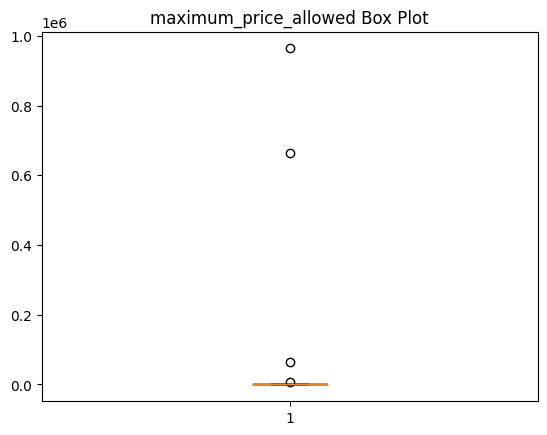

In [ ]:
print(df_vamstar['maximum_price_allowed'].describe())
fig1, ax1 = plt.subplots()
ax1.set_title('maximum_price_allowed Box Plot')
ax1.boxplot(df_vamstar.maximum_price_allowed)
plt.show()

## Final Output

Based on the sample size the only modification I would feel confident doing would be removing index 28, since it does not meet the conditions required. The other modification we have done is dropping the 'atc' column and splitting the column 'participant_price'

In [ ]:
df_vamstar_clean= df_vamstar[df_vamstar.index !=28]

Other cleaning steps to simplify the model could be to remove unnecessary columns, in this case columns like 'active_ingredient' & 'pack_strength', which always take the same value.

I think its a **best-practice to automate as much as possible** if the objective is to scale up the size of the dataset, hence why I have focused on creating functions instead of straigh analysis.

To improve in the long term I would focus on developing a good cleaning script that would look at all the possible errors we could encounter, followed my manual check ups of data to find new anomalies that were not taken into consideration in the original script. From past experiences I have realised that its a process of continous improvement, continous validations and step by step analysis when the validations are not completed. The objective of making the analysis step by step is to be able to segment the table until you identify te matter of the issue.

In [ ]:
df_vamstar_clean

,contract_id,published_date,start_date,duration_extension,outcome,second_place_outcome,buyer,region,duration,contract_type,sku,end_date_extension,participants_no,quantity_annual,quantity_total,maximum_price_allowed,active_ingredient,pack_strength,participants,published_date_month,winner,winner_price,second_place,second_place_price,participants_price_1,participants_price_2,participants_price_3,participants_price_4
0,1,2013-05-16,2013-05-24,10,won,NaN,buyer_1,region_1,39,regional,molecule_x_10mg_tablet,2017-06-30,1,9860,3.296651e+04,0.10000,molecule_x,10mg,participants_16,2013-05-01,participants_16,0.00040,NaN,NaN,0.0004,None,None,None
1,2,2013-04-29,2013-06-21,0,won,NaN,buyer_2,region_2,48,wide area,molecule_x_10mg_tablet,2017-06-30,1,54988,2.202494e+05,63442.21000,molecule_x,10mg,participants_16,2013-04-01,participants_16,0.00700,NaN,NaN,0.007,None,None,None
2,3,2013-06-09,2014-08-14,6,won,lost,buyer_3,region_3,12,regional,molecule_x_10mg_tablet,2016-02-14,2,1904,2.680639e+03,0.11635,molecule_x,10mg,participants_16|participants_23,2013-06-01,participants_16,0.01400,participants_23,0.070710,0.014,0.07071,None,None
3,4,2013-05-04,2013-05-17,19,won,NaN,buyer_4,region_4,36,regional,molecule_x_10mg_tablet,2017-12-31,1,1652,5.900676e+03,0.03000,molecule_x,10mg,participants_16,2013-05-01,participants_16,0.02500,NaN,NaN,0.025,None,None,None
4,5,2013-12-18,2013-12-17,6,won,NaN,buyer_5,region_5,36,regional,molecule_x_10mg_tablet,2017-06-30,1,1000,3.289223e+03,0.00010,molecule_x,10mg,participants_16,2013-12-01,participants_16,0.00001,NaN,NaN,1e-05,None,None,None
5,6,2013-12-06,2014-02-21,14,won,NaN,buyer_6,region_6,48,regional,molecule_x_10mg_tablet,2019-04-20,1,2088,9.026168e+03,0.02550,molecule_x,10mg,participants_16,2013-12-01,participants_16,0.01900,NaN,NaN,0.019,None,None,None
6,7,2014-02-24,2014-01-01,3,won,NaN,buyer_7,region_7,12,regional,molecule_x_10mg_tablet,2015-03-31,1,16490,1.728231e+04,0.00005,molecule_x,10mg,participants_16,2014-02-01,participants_16,0.00001,NaN,NaN,1e-05,None,None,None
7,8,2014-03-08,2014-05-22,10,won,lost,buyer_8,region_8,36,regional,molecule_x_10mg_tablet,2018-03-22,4,10332,3.195179e+04,0.08000,molecule_x,10mg,participants_16|participants_5|participants_6|...,2014-03-01,participants_16,0.03000,participants_6,0.034000,0.03,0.08,0.034,0.04066
8,9,2014-03-18,2014-05-30,6,won,NaN,buyer_9,region_9,24,regional,molecule_x_10mg_tablet,2016-11-29,1,17413,3.501392e+04,0.00010,molecule_x,10mg,participants_16,2014-03-01,participants_16,0.00001,NaN,NaN,1e-05,None,None,None
9,10,2014-09-07,2014-08-31,7,won,NaN,buyer_10,region_10,36,regional,molecule_x_10mg_tablet,2020-03-31,1,3467,1.076659e+04,0.00010,molecule_x,10mg,participants_16,2014-09-01,participants_16,0.00010,NaN,NaN,0.0001,None,None,None
